In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

# 1 获取数据集

In [2]:
data_dir = d2l.download_extract('hotdog')

In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

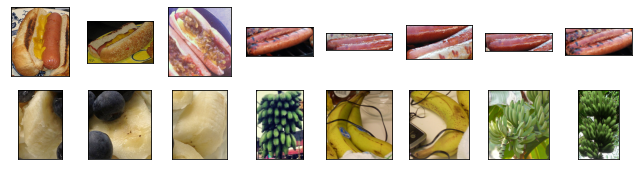

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)

In [76]:
hotdogs[1].numpy()

AttributeError: numpy

In [5]:
# 使用三个RGB通道的均值和标准偏差，以标准化每个通道(因为ImageNet模型就这么干的)
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])
# 将图像的高度和宽度都缩放到 256 像素，然后裁剪中央 $224 \times 224$ 区域作为输入
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

# 2 定义和初始化模型

In [6]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
# 预训练的源模型实例包含许多特征层和一个输出层 `fc`。
pretrained_net.fc

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\91342/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Linear(in_features=512, out_features=1000, bias=True)

In [7]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

# 3 微调模型

In [8]:
# 如果 `param_group=True`，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)    
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.211, train acc 0.920, test acc 0.940
10.2 examples/sec on [device(type='cpu')]


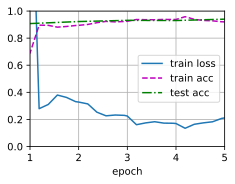

In [9]:
train_fine_tuning(finetune_net, 5e-5)

In [14]:
y_hat = torch.tensor([[0.2, 0.6, 0.2]])
y = torch.tensor([2])
-torch.log(y_hat[range(len(y_hat)), y])

tensor([1.6094])

In [16]:
y_hat[range(len(y_hat)), y]

tensor([0.2000])

In [210]:
data_path = '../data/hotdog'
augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    # torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor()])
test_img = torchvision.datasets.ImageFolder(os.path.join(data_path, 'test')) # 用于展示图片
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_path, 'test'), transform=augs) # 用于预测
X, y = next(iter(torch.utils.data.DataLoader(test_imgs, batch_size=8, shuffle=True)))

In [219]:
import numpy as np
index = np.array(10)
# X = torch.stack([test_imgs[i][0] for i in range(10)], dim = 0)

# finetune_net(X)
X = [test_img[i][0] for i in range(10)]

In [220]:
def get_hotdog_labels(labels):
    text_labels = ["hotdog", "not hotdog"]
    return [text_labels[i] for i in labels]

array([<AxesSubplot:title={'center':'hotdog'}>,
       <AxesSubplot:title={'center':'hotdog'}>,
       <AxesSubplot:title={'center':'not hotdog'}>,
       <AxesSubplot:title={'center':'not hotdog'}>,
       <AxesSubplot:title={'center':'not hotdog'}>,
       <AxesSubplot:title={'center':'hotdog'}>,
       <AxesSubplot:title={'center':'hotdog'}>,
       <AxesSubplot:title={'center':'not hotdog'}>], dtype=object)

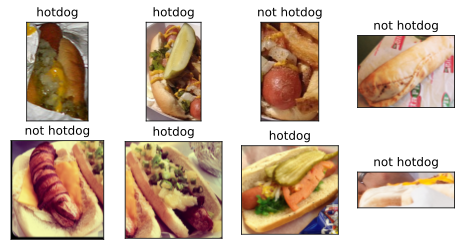

In [222]:
n=8
titles = get_hotdog_labels(y)
# 对于tensor的图形，3*224*224需要变成224*224*3, PIL不需要
# img = X.swapaxes(1,2) 
# img = img.swapaxes(2,3)
d2l.show_images(X[0:n], 2, n // 2, titles=titles[0:n], scale=2)

In [179]:
def get_rand_index(data_range, batch_size):
    return np.random.randint(0, data_range, batch_size)

array([<AxesSubplot:title={'center':'not hotdog\nnot hotdog'}>,
       <AxesSubplot:title={'center':'not hotdog\nnot hotdog'}>,
       <AxesSubplot:title={'center':'hotdog\nnot hotdog'}>,
       <AxesSubplot:title={'center':'not hotdog\nnot hotdog'}>,
       <AxesSubplot:title={'center':'not hotdog\nnot hotdog'}>,
       <AxesSubplot:title={'center':'not hotdog\nnot hotdog'}>,
       <AxesSubplot:title={'center':'hotdog\nhotdog'}>,
       <AxesSubplot:title={'center':'not hotdog\nnot hotdog'}>],
      dtype=object)

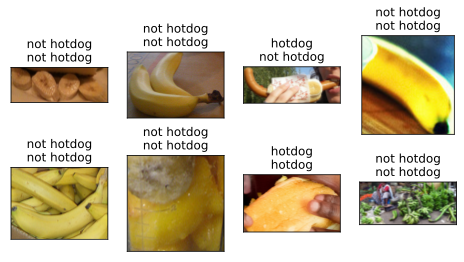

In [227]:
import torchvision
from torchvision.datasets import *
from torch.utils.data import DataLoader
from torch import nn, optim
idx = get_rand_index(len(test_imgs_ori), 8)
imgs = [ImageFolder(os.path.join(data_path, 'test'))[i][0] for i in idx]
X = torch.stack([test_imgs[i][0] for i in idx], dim=0)
y = [test_imgs[i][1] for i in idx]
trues = get_hotdog_labels(y)
with torch.no_grad():
    preds = get_hotdog_labels(finetune_net(X).argmax(axis=1))
titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
n = 8
d2l.show_images(imgs[0:n], 2, n // 2, titles=titles[0:n], scale=2)